In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)
print(pd.__version__)

0.25.3


/home/miguel/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/miguel/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [4]:
def get_Dataframe(path, name='Data', tag=None, isMC=False):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        if( df is not None):
            if(df.shape[0]>5000000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if (isMC):
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [5]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [6]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_pz = jet_pt*sinh(jet_eta)', inplace=True)

    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    
    temp.eval('qt_px = jet_px + e_px', inplace=True)
    temp.eval('qt_py = jet_py + e_py', inplace=True)
    temp.eval('qt_phi = arctan(qt_py/qt_px)',inplace=True)
    temp.eval('qt_dot_ept = (qt_px*e_px + qt_py*e_py)/(jet_qt*e_pt)', inplace=True)
    temp.eval('qt_dphi = arccos(qt_dot_ept)', inplace=True)
    temp.eval('qt_cos2phi = cos(2*qt_dphi)', inplace=True)

    temp.eval('jet_dphi = abs(e_phi-jet_phi)',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp.eval('pthoverpte = pth/e_pt', inplace=True)
    temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    temp = applyCut(temp, 'pass_reco==0 | 0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'pass_reco==0 | Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | Q2<10000', 'Q2<10000')
    temp = applyCut(temp, 'pass_reco==0 | Empz<65', 'Empz<65')
    temp = applyCut(temp, 'pass_reco==0 | Empz>45', 'Empz>45')


    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt<150.0', 'jet pT < 150 GeV')

    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.5', 'jet eta > -1.5')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.75', 'jet eta < 2.75')

    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_pz = genjet_pt*sinh(genjet_eta)', inplace=True)

        
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = abs(gene_phi-genjet_phi)',inplace=True)
        
        temp.eval('genqt_px = genjet_px + gene_px', inplace=True)
        temp.eval('genqt_py = genjet_py + gene_py', inplace=True)
        temp.eval('genqt_phi = arctan(genqt_py/genqt_px)',inplace=True)
        temp.eval('genqt_dot_ept = (genqt_px*gene_px + genqt_py*gene_py)/(genjet_qt*gene_pt)', inplace=True)
        temp.eval('genqt_dphi = arccos(genqt_dot_ept)', inplace=True)
        temp.eval('genqt_cos2phi = cos(2*genqt_dphi)', inplace=True)

    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [7]:
#mc_name = 'Django'
#altmc_name = 'Rapgap'

mc_name = 'Rapgap'
altmc_name = 'Django'

In [8]:
mc_tag = 'nominal' ##could be "sys_0 or sys_1, etc"
data_tag  = 'nominal'
period = 'ep0607'

## Here use RAPGAP as data (pseudodata for the closure test)

In [9]:
path = '/home/miguel/data/hera/'
data = get_Dataframe(path, name=altmc_name, tag=data_tag)
print (data.keys())

filename is /home/miguel/data/hera/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_134.nominal.root
[b'Django;1']
####################################################################
Dataframe has a total of  5973690  entries
####################################################################
Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'Q2', 'y', 'e_px',
       'e_py', 'e_pz', 'wgt', 'vertex_z', 'ptmiss', 'ptratio_da',
       'ptratio_ele', 'Empz', 'pth'],
      dtype='object')


## Get Signal MC

In [10]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag, isMC=True)
print (mc.keys())

filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
####################################################################
Dataframe has a total of  5709963  entries
####################################################################
Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth'],
      dtype='object')
CPU times: user 9.03 s, sys: 428 ms, total: 9.46 s
Wall time: 9.62 s


In [11]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag, isMC=True)
print (altmc.keys())

filename is /home/miguel/data/hera/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_134.nominal.root
[b'Django;1']
####################################################################
Dataframe has a total of  5973690  entries
####################################################################
Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth'],
      dtype='object')
CPU times: user 9.06 s, sys: 379 ms, total: 9.44 s
Wall time: 9.45 s


## Define the pass_reco and pass_tuth flags. i.e. whether row in the dataframe jet has a reco-level jet, and whether it has a valid truth-level jet. 

In [12]:
%%time 
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['genjet_pt']*mc['Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['genjet_pt']*altmc['Q2']>0, 1, 0)



CPU times: user 94.3 ms, sys: 10.6 ms, total: 105 ms
Wall time: 88.2 ms


In [13]:
%%time 
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)
data = data.query('pass_reco==1')
print('Selecting data events\n')
data = applyCutsJets(data)
data.keys()

Selecting data events

ptmiss<10 1371590  fraction kept: 98.4
0.08 < y < 0.7 1254892  fraction kept: 91.5
Q2>150 1080744  fraction kept: 86.1
Q2<10000 1079861  fraction kept: 99.9
Empz<65 1079861  fraction kept: 100.0
Empz>45 1079861  fraction kept: 100.0
jet pT > 5 GeV 1079861  fraction kept: 100.0
jet pT < 150 GeV 1079861  fraction kept: 100.0
jet eta > -1.5 1078428  fraction kept: 99.9
jet eta < 2.75 1078392  fraction kept: 100.0
CPU times: user 1.39 s, sys: 181 ms, total: 1.57 s
Wall time: 1.16 s


Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'Q2', 'y', 'e_px',
       'e_py', 'e_pz', 'wgt', 'vertex_z', 'ptmiss', 'ptratio_da',
       'ptratio_ele', 'Empz', 'pth', 'pass_reco', 'jet_px', 'jet_py', 'jet_pz',
       'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi',
       'qt_dot_ept', 'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte'],
      dtype='object')

In [14]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

Selecting MC events

ptmiss<10 5695953  fraction kept: 99.8
0.08 < y < 0.7 5571241  fraction kept: 97.8
Q2>150 5418864  fraction kept: 97.3
Q2<10000 5417886  fraction kept: 100.0
Empz<65 5417886  fraction kept: 100.0
Empz>45 5417886  fraction kept: 100.0
jet pT > 5 GeV 5417886  fraction kept: 100.0
jet pT < 150 GeV 5417886  fraction kept: 100.0
jet eta > -1.5 5416419  fraction kept: 100.0
jet eta < 2.75 5416388  fraction kept: 100.0
 pass_truth>0 1414891  fraction kept: 26.1
Selecting MC events

ptmiss<10 5951602  fraction kept: 99.6
0.08 < y < 0.7 5834904  fraction kept: 98.0
Q2>150 5660756  fraction kept: 97.0
Q2<10000 5659873  fraction kept: 100.0
Empz<65 5659873  fraction kept: 100.0
Empz>45 5659873  fraction kept: 100.0
jet pT > 5 GeV 5659873  fraction kept: 100.0
jet pT < 150 GeV 5659873  fraction kept: 100.0
jet eta > -1.5 5658440  fraction kept: 100.0
jet eta < 2.75 5658404  fraction kept: 100.0
 pass_truth>0 1385814  fraction kept: 24.5
CPU times: user 10 s, sys: 2.99 s, total

## Show all distributions

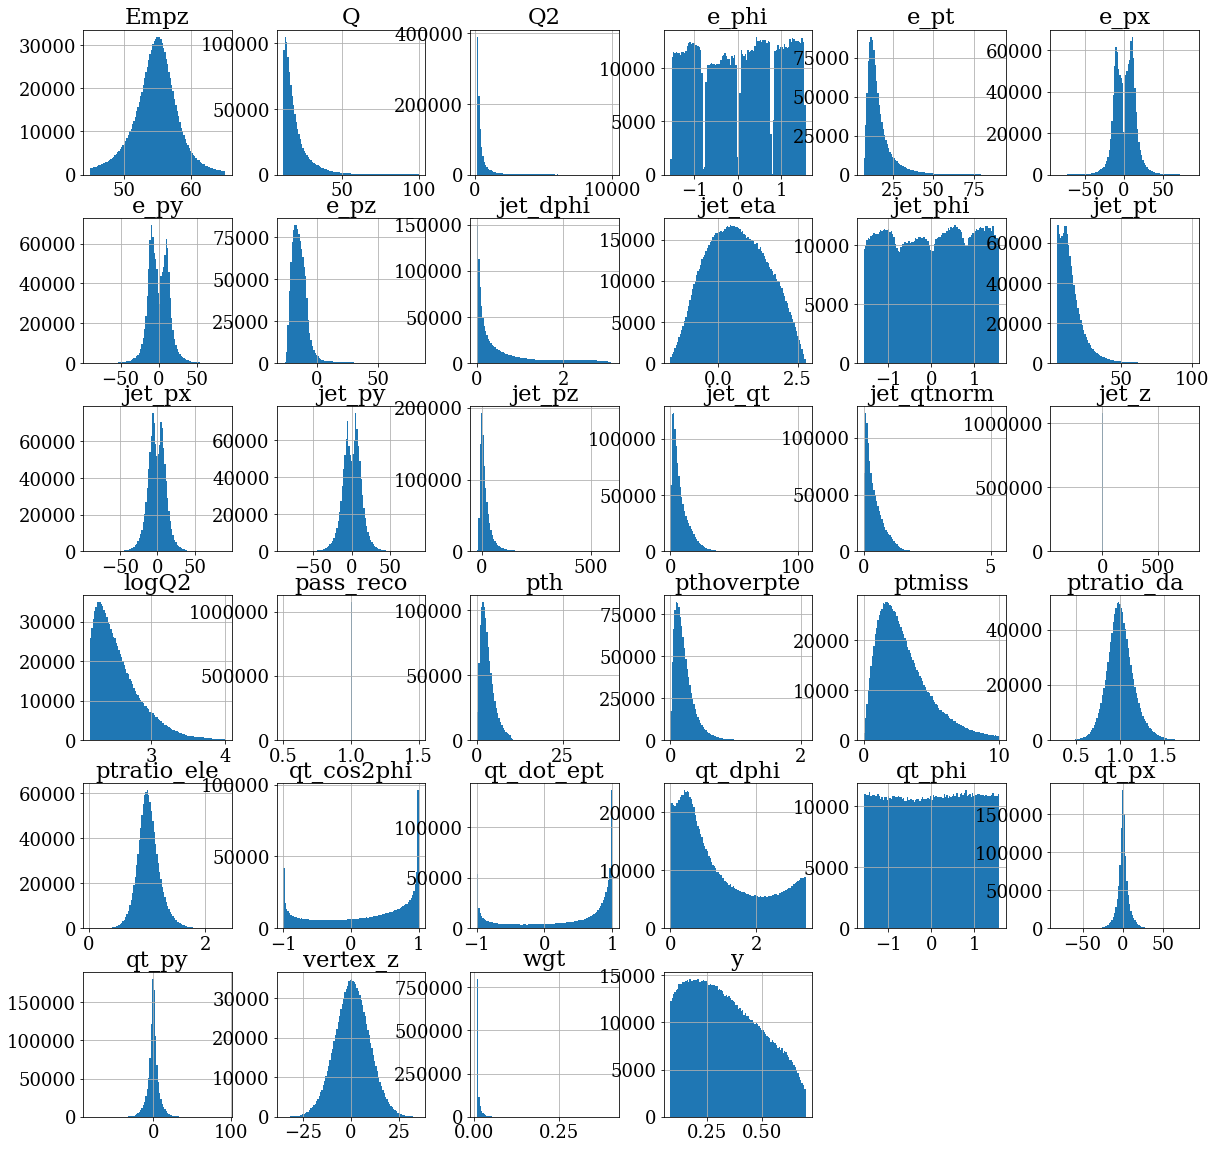

In [15]:
data.query('pass_reco==1').hist(figsize=(20,20),bins=100)
plt.show()

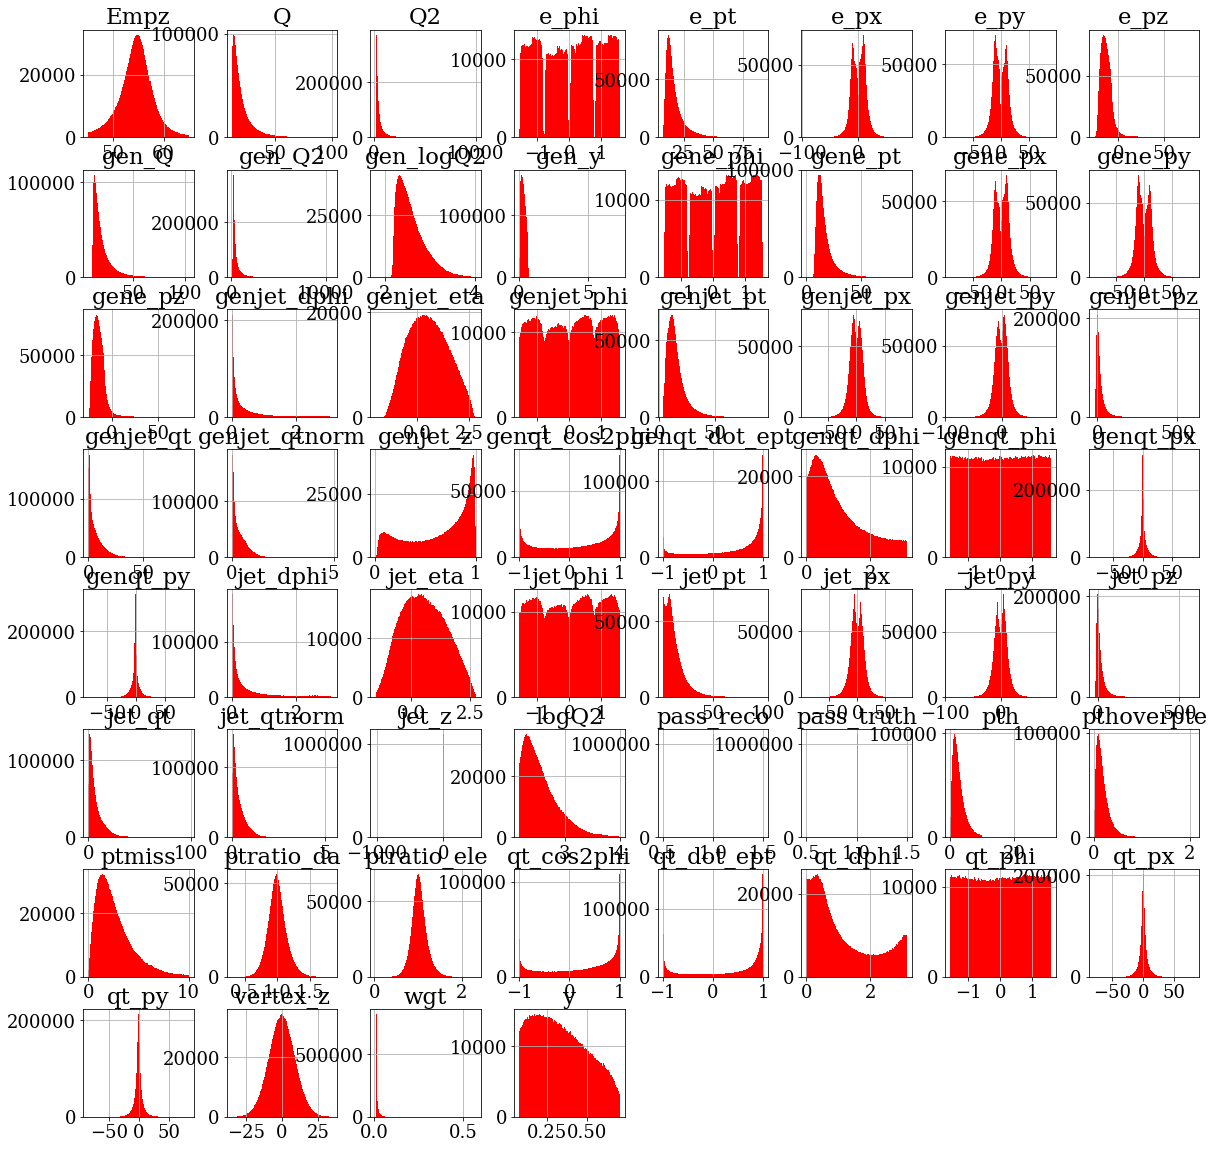

In [16]:
mc.query('pass_reco==1').hist(figsize=(20,20),bins=100,color='red')
plt.show()

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


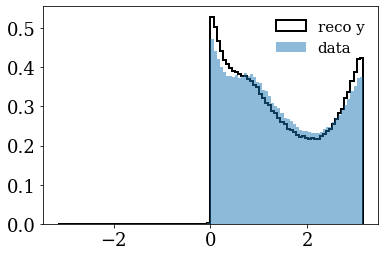

In [17]:
plt.hist(mc.query('pass_reco==1 and jet_pt>10')['qt_dphi'], range=(-np.pi,np.pi),bins=100,**plot_style_1,label='reco y')
plt.hist(data.query('jet_pt>10')['qt_dphi'],range=(-np.pi,np.pi),bins=100, **plot_style_2, label='data')
plt.legend()
plt.show()

## Event selection

In [18]:
label_DISselection = r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$'

In [19]:
data.head()

jet_pt   jet_phi   jet_eta  jet_dphi     jet_z  \
entry subentry                                                      
1     0         10.843917  0.645760 -0.079351  0.347061  0.994078   
8     0         14.971306  0.406741  1.119547  0.053167  0.882479   
15    0         44.576412 -0.596459  0.445278  0.035226  0.888181   
18    0         14.344785 -1.005179  1.160051  0.746780  0.399016   
      1         10.584982  0.447149  0.912105  0.705548  0.433405   

                         Q2         y       e_px       e_py       e_pz  ...  \
entry subentry                                                          ...   
1     0          175.455582  0.244163 -11.175168  -3.440961 -19.918161  ...   
8     0          357.716492  0.151013 -15.923836  -7.887619 -21.124395  ...   
15    0         5858.060547  0.570241  41.211361 -25.908264  41.897808  ...   
18    0          442.950928  0.198765  18.044886  -4.769410 -17.694183  ...   
      1          442.950928  0.198765  18.044886  -4.769410 -17.694183  ...   

                   e_phi      qt_px     qt_py    qt_phi  qt_dot_ept   qt_dphi  \
entry subentry                                                                  
1     0         0.298699  -2.514755  3.084970 -0.886877    0.375763  1.185576   
8     0         0.459908  -2.173963 -1.964696  0.734877    0.962433  0.274970   
15    0        -0.561233   4.331966 -0.868958 -0.197965    0.934741  0.363268   
18    0        -0.258399  10.356981  7.341287  0.616624    0.640979  0.875023   
      1        -0.258399   8.500583 -9.346321 -0.832751    0.839544  0.574352   

                qt_cos2phi     logQ2          Q  pthoverpte  
entry subentry                                               
1     0          -0.717604  2.244168  13.245965    0.347506  
8     0           0.852556  2.553539  18.913395    0.229163  
15    0           0.747480  3.767754  76.537971    0.146364  
18    0          -0.178292  2.646356  21.046400    0.017195  
      1           0.409670  2.646356  21.046400    0.017195  

[5 rows x 34 columns]

In [20]:
mc.head()

jet_pt   jet_phi      jet_eta  jet_dphi        jet_z  \
entry subentry                                                              
2     0           16.420273  1.553756     0.587027  3.044224     0.728761   
      1            9.641730 -1.456244     1.784029  0.034224     0.161802   
4     0           14.567807 -0.377384    -0.395859  0.524154     0.679185   
      1        -9999.000000  0.689416 -9999.000000  1.590954 -9999.000000   
      2        -9999.000000  0.689416 -9999.000000  1.590954 -9999.000000   

                genjet_pt  genjet_phi  genjet_eta  genjet_z          Q2  ...  \
entry subentry                                                           ...   
2     0         20.568708   -1.467425    0.821434  0.846955  788.595337  ...   
      1          5.473908   -1.346081    2.155561  0.054393  788.595337  ...   
4     0         14.085672   -0.397176   -0.393945  0.653461  212.734039  ...   
      1          5.879607    0.214298    0.837583  0.115509  212.734039  ...   
      2          3.192867   -1.526671    1.398180  0.033691  212.734039  ...   

                genjet_qt  genjet_qtnorm  gene_phi  genjet_dphi   genqt_px  \
entry subentry                                                               
2     0          3.541956       0.127100 -1.491610     0.024185  -0.218442   
      1         18.670387       0.669973 -1.491610     0.145529   0.684249   
4     0          7.555617       0.523518 -0.901228     0.504051  -7.374407   
      1         12.774529       0.885129 -0.901228     1.115525  11.359911   
      2          6.723284       0.465847 -0.901228     0.625444   5.473955   

                 genqt_py  genqt_phi  genqt_dot_ept  genqt_dphi  genqt_cos2phi  
entry subentry                                                                  
2     0         -3.535213   1.509084       0.990090    0.140898       0.960558  
      1        -18.657845  -1.534139       0.999096    0.042530       0.996385  
4     0         -1.644833   0.219454      -0.435069    2.020911      -0.621430  
      1         -5.843030  -0.475066       0.910559    0.426162       0.658236  
      2         -3.903635  -0.619483       0.960572    0.281744       0.845397  

[5 rows x 60 columns]

### Define UniFold Algorithm


In [21]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))





def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)
def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,weights_MC_sim=None,weights_MC_data=None,verbose=1):
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(theta0_S))
    
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(theta_unknown_S))
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    
    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    dropoutlayer = Dropout(0.1)(hidden_layer_1)
    hidden_layer_2 = Dense(50, activation='relu')(dropoutlayer)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    earlystopping = EarlyStopping(patience=30,
                              verbose=verbose,
                              restore_best_weights=True)
    
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=8000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim
    
    #weights_pull = np.ones(len(theta0_S))
    #weights_push = np.ones(len(theta0_S))
    
    history = {}
    history['step1'] = []
    history['step2'] = []
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))
        print("STEP 1\n")
        
        weights_1 = np.concatenate((weights_push,weights_MC_data ))
        
        
      
        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
        
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
        batch_size=8000
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        
        hist_s1 =  model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step1'].append(hist_s1)
        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1
        weights[i, :1, :] = weights_pull
        
        print("\nSTEP 2\n")
        weights_2 = np.concatenate((weights_MC_sim, weights_pull))

        #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth
        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)
    
        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        hist_s2 = model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step2'].append(hist_s2)

        #weights_push = reweight(theta0_G)
        weights_push = weights_MC_sim * reweight(theta0_G)

        weights[i, 1:2, :] = weights_push
   
    return weights, model, history

    




In [22]:
print(tf.__version__)
print(tensorflow.keras.__version__)

print(np.__version__)

2.3.1
2.4.0
1.17.4


In [23]:
tf.random.set_seed(1234)
np.random.seed(1234)

## Define features with data

In [24]:
data_cut = data[:1000000]
n = int(len(data_cut)*1.5)
mc_cut = mc[:n]


print(len(mc_cut))
print(len(data_cut))

1414891
1000000


In [25]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
ratio = len(mc_cut.query('pass_reco==1'))/len(data_cut)
print(ratio)

1000000
1099371
1414891
1.099371


In [26]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth',
       'pass_reco', 'pass_truth', 'jet_px', 'jet_py', 'jet_pz', 'jet_qt',
       'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi', 'qt_dot_ept',
       'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte', 'gen_logQ2',
       'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py', 'genjet_pz', 'genjet_qt',
       'genjet_qtnorm', 'gene_phi', 'genjet_dphi', 'genqt_px', 'genqt_py',
       'genqt_phi', 'genqt_dot_ept', 'genqt_dphi', 'genqt_cos2phi'],
      dtype='object')

In [27]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_S = data_cut['jet_qt']


qtdphi_0_G = mc_cut['genqt_dphi']
qtdphi_0_S = mc_cut['qt_dphi']
qtdphi_unknown_S = data_cut['qt_dphi']


weights_MC_sim = mc_cut['wgt']
weights_MC_data = data_cut['wgt']
# Q_0_G           = mc_cut['gen_Q']
# Q_0_S           = mc_cut['Q']
# Q_unknown_S     = data_cut['Q']

In [28]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S )]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [29]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10



<ipython-input-30-c55f2ce48ade>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-30-c55f2ce48ade>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


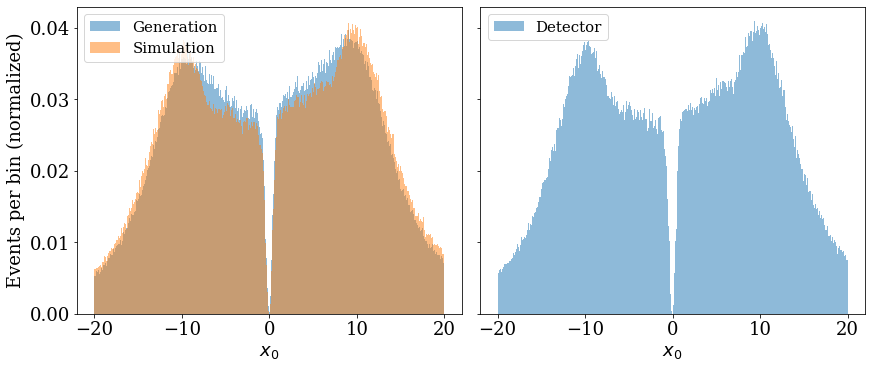

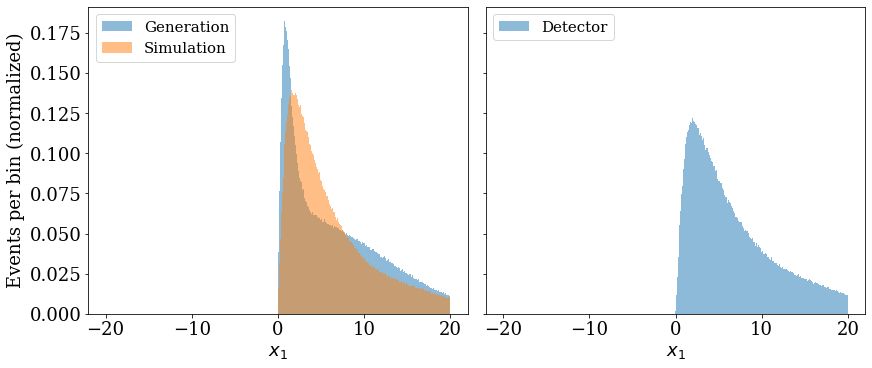

In [30]:
bins = np.linspace(-20,20,400)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

#bins = np.linspace(-180,180, 101)
#bins = np.linspace(0,2, 101)
bins = np.linspace(-20,20,400)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1],bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Run unfolding on data

In [31]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [32]:
%%time 
iterations =5# use ~4 iterations
num_observables= 8
K.clear_session()
weights, _, history = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,verbose=1,weights_MC_sim=weights_MC_sim)


ITERATION: 1

STEP 1

Epoch 1/200
227/227 [==============================] - 1s 2ms/step - loss: 0.1110 - accuracy: 0.4084 - val_loss: 0.0645 - val_accuracy: 0.4152
Epoch 2/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.4137 - val_loss: 0.0629 - val_accuracy: 0.4152
Epoch 3/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.4137 - val_loss: 0.0621 - val_accuracy: 0.4152
Epoch 4/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0544 - accuracy: 0.4310 - val_loss: 0.0318 - val_accuracy: 0.4808
Epoch 5/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.4790 - val_loss: 0.0316 - val_accuracy: 0.4808
Epoch 6/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.4790 - val_loss: 0.0315 - val_accuracy: 0.4808
Epoch 7/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.4790 - val_loss: 0.0315

Epoch 58/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy: 0.4808
Epoch 59/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy: 0.4808
Epoch 60/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy: 0.4808
Epoch 61/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy: 0.4808
Epoch 62/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy: 0.4808
Epoch 63/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy: 0.4808
Epoch 64/200
227/227 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.4790 - val_loss: 0.0313 - val_accuracy:

266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 5/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 6/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3067
Epoch 7/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 8/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 9/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 10/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 11/2

266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 62/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 63/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 64/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 65/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 66/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch 67/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3054 - val_loss: 0.0351 - val_accuracy: 0.3067
Epoch

Epoch 22/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.3949 - val_loss: 0.5800 - val_accuracy: 0.4261
Epoch 23/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.3953 - val_loss: 0.5796 - val_accuracy: 0.4022
Epoch 24/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.3948 - val_loss: 0.5796 - val_accuracy: 0.4127
Epoch 25/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.3957 - val_loss: 0.5797 - val_accuracy: 0.3626
Epoch 26/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5792 - accuracy: 0.3941 - val_loss: 0.5795 - val_accuracy: 0.4056
Epoch 27/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5792 - accuracy: 0.3948 - val_loss: 0.5794 - val_accuracy: 0.3889
Epoch 28/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5792 - accuracy: 0.3944 - val_loss: 0.5794 - val_accuracy:

Epoch 79/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3967 - val_loss: 0.5790 - val_accuracy: 0.3925
Epoch 80/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3970 - val_loss: 0.5791 - val_accuracy: 0.4030
Epoch 81/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3979 - val_loss: 0.5791 - val_accuracy: 0.3832
Epoch 82/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3973 - val_loss: 0.5790 - val_accuracy: 0.3958
Epoch 83/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3975 - val_loss: 0.5794 - val_accuracy: 0.4222
Epoch 84/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3976 - val_loss: 0.5792 - val_accuracy: 0.3858
Epoch 85/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.3978 - val_loss: 0.5791 - val_accuracy:

227/227 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.3973 - val_loss: 0.5790 - val_accuracy: 0.3963
Epoch 136/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.3973 - val_loss: 0.5789 - val_accuracy: 0.3966
Epoch 137/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.3968 - val_loss: 0.5790 - val_accuracy: 0.3727
Epoch 138/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.3971 - val_loss: 0.5790 - val_accuracy: 0.3791
Epoch 139/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.3962 - val_loss: 0.5789 - val_accuracy: 0.3894
Epoch 140/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.3964 - val_loss: 0.5790 - val_accuracy: 0.3862
Epoch 141/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.3955 - val_loss: 0.5792 - val_accuracy: 0.3789

Epoch 00190: early stopping

STEP 2

Epoch 1/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0551 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3055
Epoch 2/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0351 - val_accuracy: 0.3055
Epoch 3/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3058 - val_loss: 0.0351 - val_accuracy: 0.3055
Epoch 4/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3058 - val_loss: 0.0351 - val_accuracy: 0.3055
Epoch 5/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3058 - val_loss: 0.0351 - val_accuracy: 0.3055
Epoch 6/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3058 - val_loss: 0.0351 - val_accuracy: 0.3055
Epoch 7/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3058 - va

Epoch 58/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 59/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 60/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 61/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 62/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 63/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 64/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy:

Epoch 115/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 116/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 117/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 118/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 119/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 120/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 121/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_ac

227/227 [==============================] - 0s 2ms/step - loss: 0.5748 - accuracy: 0.3976 - val_loss: 0.5754 - val_accuracy: 0.4182
Epoch 42/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5748 - accuracy: 0.3979 - val_loss: 0.5752 - val_accuracy: 0.3838
Epoch 43/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.3979 - val_loss: 0.5753 - val_accuracy: 0.4150
Epoch 44/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.3985 - val_loss: 0.5753 - val_accuracy: 0.4115
Epoch 45/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.3989 - val_loss: 0.5752 - val_accuracy: 0.4009
Epoch 46/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.3983 - val_loss: 0.5755 - val_accuracy: 0.4028
Epoch 47/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.3971 - val_loss: 0.5754 - val_accuracy: 0.3635
Epoch

Epoch 00097: early stopping

STEP 2

Epoch 1/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0520 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3055
Epoch 2/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0352 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 3/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 4/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 5/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 6/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 7/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3058 - va

Epoch 58/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 59/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 60/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 61/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 62/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 63/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy: 0.3055
Epoch 64/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0349 - accuracy: 0.3058 - val_loss: 0.0350 - val_accuracy:

227/227 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.3918 - val_loss: 0.5751 - val_accuracy: 0.4303
Epoch 17/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.3930 - val_loss: 0.5762 - val_accuracy: 0.4700
Epoch 18/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.3925 - val_loss: 0.5752 - val_accuracy: 0.4329
Epoch 19/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.3928 - val_loss: 0.5753 - val_accuracy: 0.4413
Epoch 20/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.3916 - val_loss: 0.5756 - val_accuracy: 0.4539
Epoch 21/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.3929 - val_loss: 0.5753 - val_accuracy: 0.4456
Epoch 22/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.3925 - val_loss: 0.5757 - val_accuracy: 0.4572
Epoch

Epoch 73/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.3916 - val_loss: 0.5748 - val_accuracy: 0.4255
Epoch 74/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.3916 - val_loss: 0.5750 - val_accuracy: 0.4361
Epoch 75/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.3927 - val_loss: 0.5748 - val_accuracy: 0.4181
Epoch 76/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.3921 - val_loss: 0.5746 - val_accuracy: 0.3679
Epoch 77/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.3920 - val_loss: 0.5746 - val_accuracy: 0.4005
Epoch 78/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.3913 - val_loss: 0.5748 - val_accuracy: 0.4273
Epoch 79/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.3934 - val_loss: 0.5747 - val_accuracy:

Epoch 130/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.3912 - val_loss: 0.5747 - val_accuracy: 0.4117
Epoch 131/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.3932 - val_loss: 0.5747 - val_accuracy: 0.4166
Epoch 132/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.3920 - val_loss: 0.5747 - val_accuracy: 0.3821
Epoch 133/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5744 - accuracy: 0.3917 - val_loss: 0.5745 - val_accuracy: 0.3964
Epoch 134/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5744 - accuracy: 0.3923 - val_loss: 0.5745 - val_accuracy: 0.3919
Epoch 135/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.3922 - val_loss: 0.5746 - val_accuracy: 0.3958
Epoch 136/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.3922 - val_loss: 0.5746 - val_ac

266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 34/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 35/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 36/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 37/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 38/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 39/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch

Epoch 90/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 91/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 92/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 93/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 94/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 95/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3060 - val_loss: 0.0351 - val_accuracy: 0.3051
Epoch 00095: early stopping

ITERATION: 5

STEP 1

Epoch 1/200
227/227 [==============================] - 0s 2ms/step - loss: 0.6931 - a

227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4147 - val_loss: 0.5691 - val_accuracy: 0.3879
Epoch 51/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4142 - val_loss: 0.5689 - val_accuracy: 0.4068
Epoch 52/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4135 - val_loss: 0.5690 - val_accuracy: 0.4232
Epoch 53/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4142 - val_loss: 0.5689 - val_accuracy: 0.4207
Epoch 54/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4138 - val_loss: 0.5689 - val_accuracy: 0.4242
Epoch 55/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4144 - val_loss: 0.5689 - val_accuracy: 0.4070
Epoch 56/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.4128 - val_loss: 0.5689 - val_accuracy: 0.4232
Epoch

Epoch 107/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4123 - val_loss: 0.5689 - val_accuracy: 0.3984
Epoch 108/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4110 - val_loss: 0.5688 - val_accuracy: 0.4071
Epoch 109/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4108 - val_loss: 0.5689 - val_accuracy: 0.4105
Epoch 110/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4116 - val_loss: 0.5689 - val_accuracy: 0.4187
Epoch 111/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4116 - val_loss: 0.5688 - val_accuracy: 0.3991
Epoch 112/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4119 - val_loss: 0.5689 - val_accuracy: 0.3883
Epoch 113/200
227/227 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.4112 - val_loss: 0.5688 - val_ac

266/266 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 16/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 17/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 18/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 19/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 20/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 21/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch

Epoch 72/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 73/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 74/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 75/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 76/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 77/200
266/266 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy: 0.3058
Epoch 78/200
266/266 [==============================] - 1s 2ms/step - loss: 0.0349 - accuracy: 0.3057 - val_loss: 0.0350 - val_accuracy:

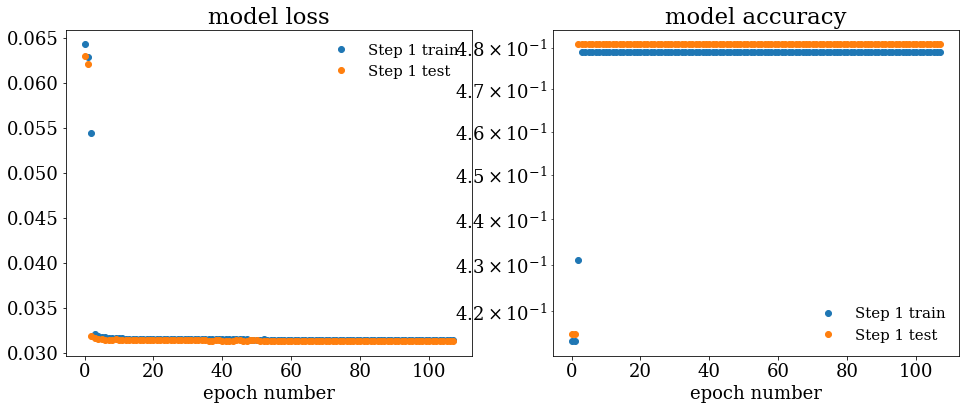

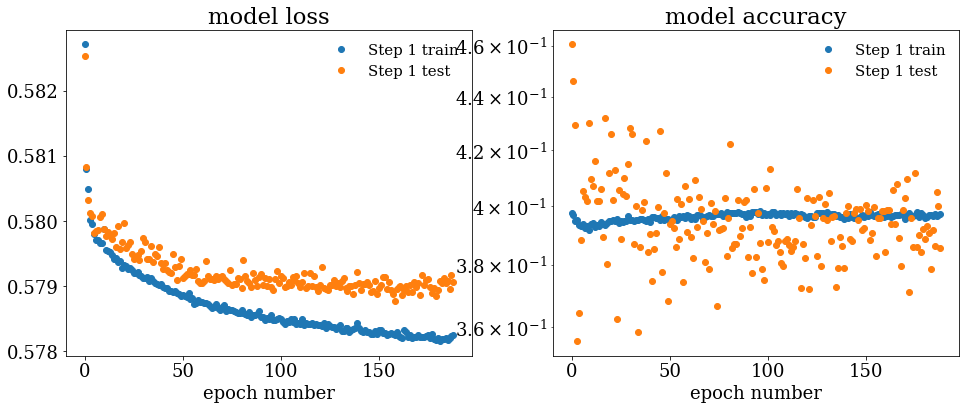

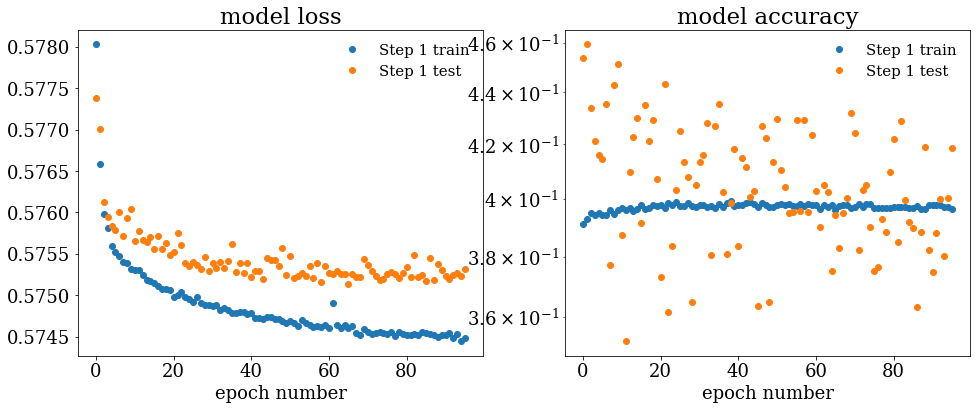

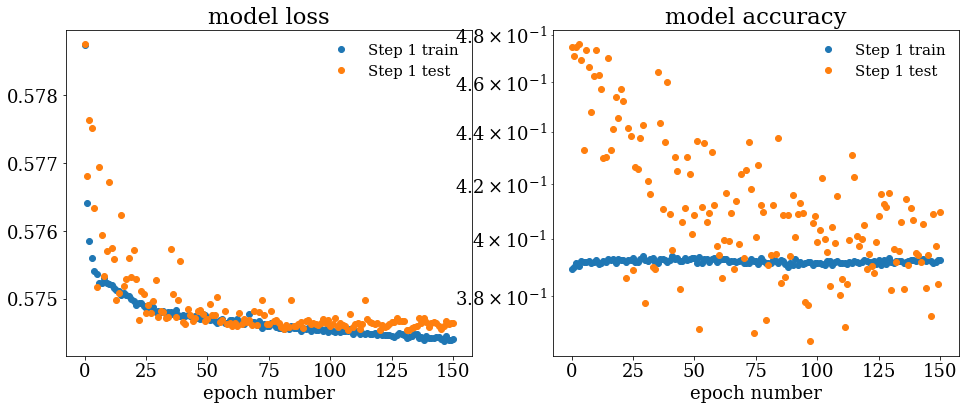

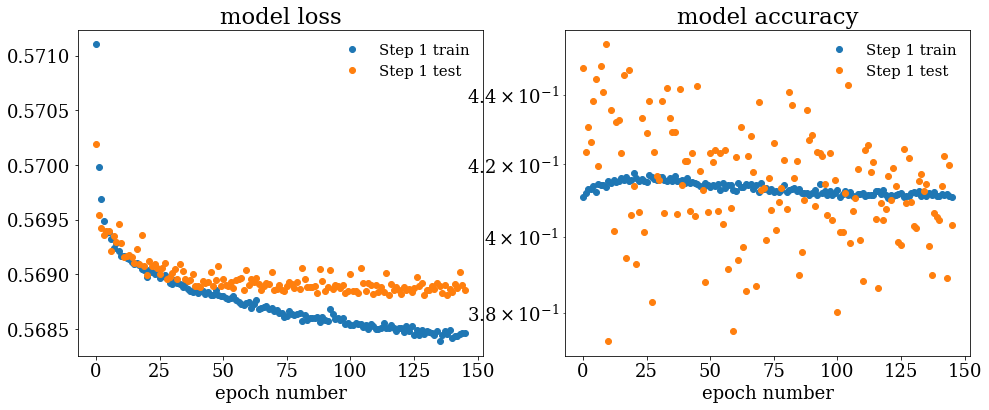

In [33]:
#list all data in history
# summarize history for accuracy
for i in range(iterations):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch number')
    ax[0].plot(history['step1'][i].history['loss'][1:],'o',label='Step 1 train')
    ax[0].plot(history['step1'][i].history['val_loss'][1:],'o',label='Step 1 test')

    ax[1].set_title('model accuracy')
    ax[1].plot(history['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
    ax[1].plot(history['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
    ax[1].legend()
    ax[1].set_xlabel('epoch number')
    ax[1].set_yscale('log')
    ax[0].legend()

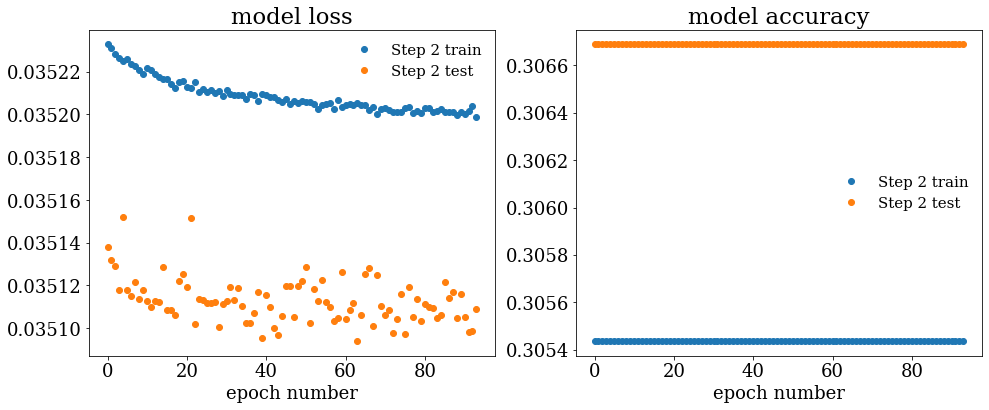

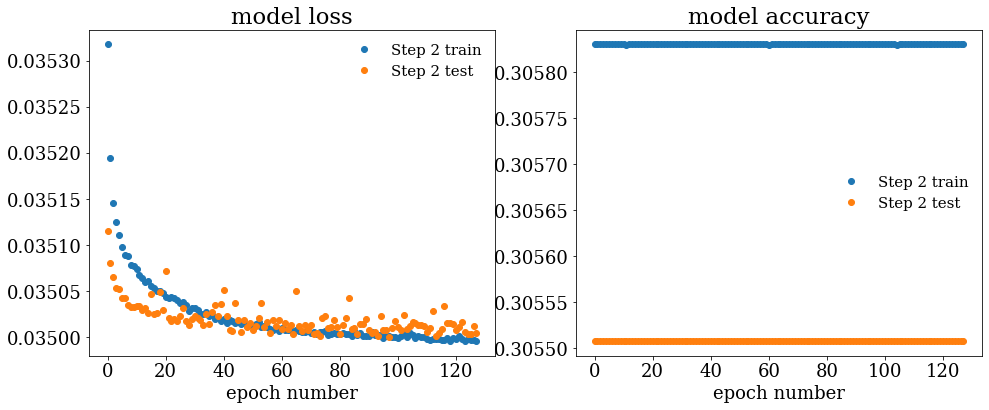

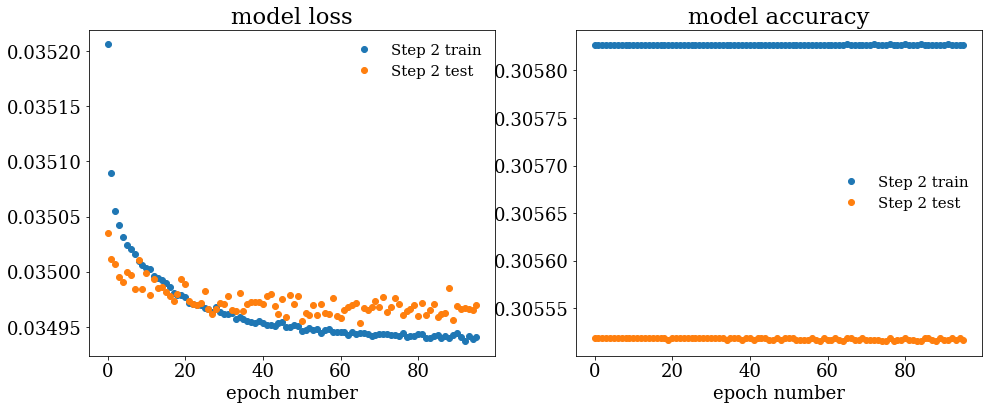

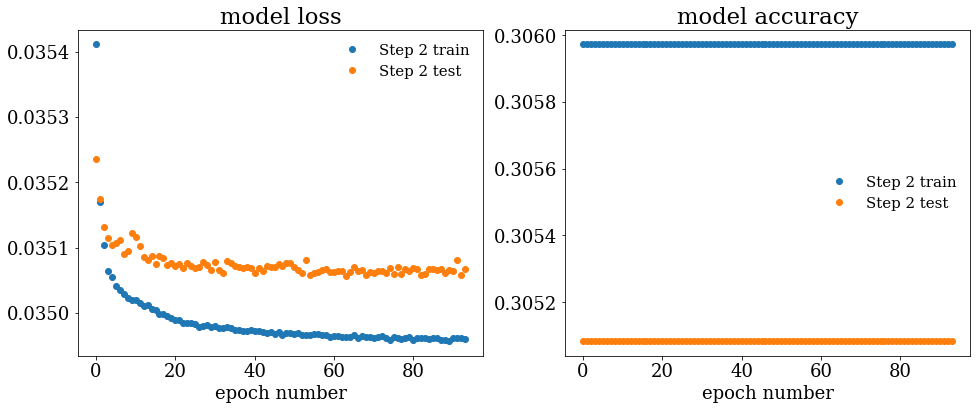

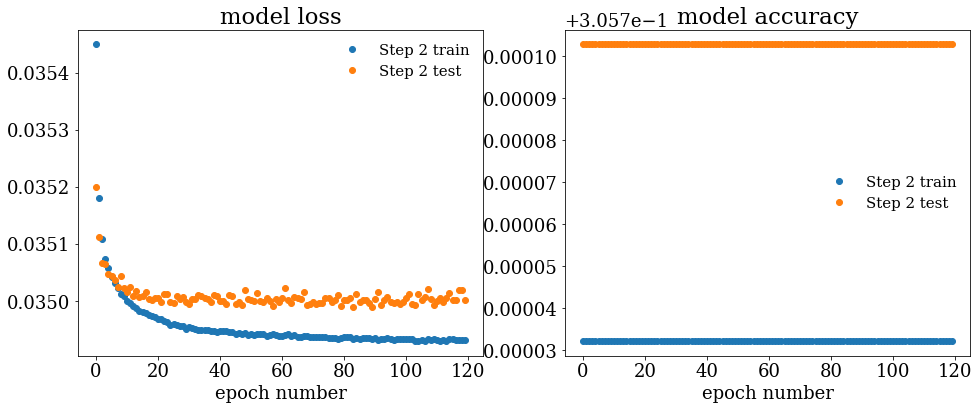

In [34]:
for i in range(iterations):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch number')
    ax[0].plot(history['step2'][i].history['loss'][1:],'o',label='Step 2 train')
    ax[0].plot(history['step2'][i].history['val_loss'][1:],'o',label='Step 2 test')

    ax[1].set_title('model accuracy')
    ax[1].plot(history['step2'][i].history['accuracy'][1:],'o',label='Step 2 train')
    ax[1].plot(history['step2'][i].history['val_accuracy'][1:],'o',label='Step 2 test')
    ax[1].legend()
    ax[1].set_xlabel('epoch number')

    ax[0].legend()

## Incorporate weights into the dataframe

In [35]:
mc_cut['weight_reco'] =  weights[-2, 0, :]
mc_cut['weight_truth'] = weights[-2, 1, :]

<ipython-input-35-afc8f285f76b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_reco'] =  weights[-2, 0, :]
<ipython-input-35-afc8f285f76b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_truth'] = weights[-2, 1, :]


In [36]:
mc_cut['weight_reco_next'] = weights[-1, 0, :]
mc_cut['weight_truth_next'] = weights[-1, 1, :]

mc_cut['weight_reco_previous'] =  weights[-3, 0, :]
mc_cut['weight_truth_previous'] = weights[-3, 1, :]


<ipython-input-36-ae014266c17d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_reco_next'] = weights[-1, 0, :]
<ipython-input-36-ae014266c17d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_truth_next'] = weights[-1, 1, :]
<ipython-input-36-ae014266c17d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

## Check weights

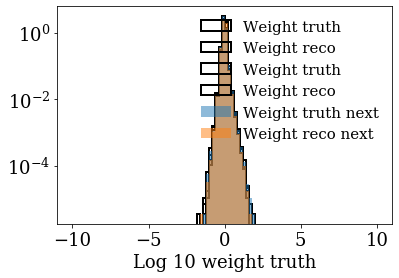

In [37]:
plt.hist(np.log10(mc_cut['weight_truth']),range=(-10,10),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),range=(-10,10),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_previous']),range=(-10,10),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco_previous']),range=(-10,10),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_next']),range=(-10,10),bins=100,**plot_style_2,label='Weight truth next')
plt.hist(np.log10(mc_cut['weight_reco_next']),range=(-10,10),bins=100,**plot_style_2, label='Weight reco next')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

#for i in range(len(weights)):
    #print ('Iteration %i'%i)
    #print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    #print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    #print(' ')

In [38]:
print(len(mc_cut))

mc_cut = mc_cut.query('weight_reco<1e4 and weight_reco>1e-3')
mc_cut = mc_cut.query('weight_truth<1e4 and weight_truth>1e-3')
print(len(mc_cut))

1414891
1414891


In [39]:
mc_cut = mc_cut.query('weight_reco_next<1e3 and weight_reco_next>1e-3')
mc_cut = mc_cut.query('weight_truth_next<1e3 and weight_truth_next>1e-3')

mc_cut = mc_cut.query('weight_reco_previous<1e3 and weight_reco_previous>1e-3')
mc_cut = mc_cut.query('weight_truth_previous<1e3 and weight_truth_previous>1e-3')

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4
ITERATION: 5


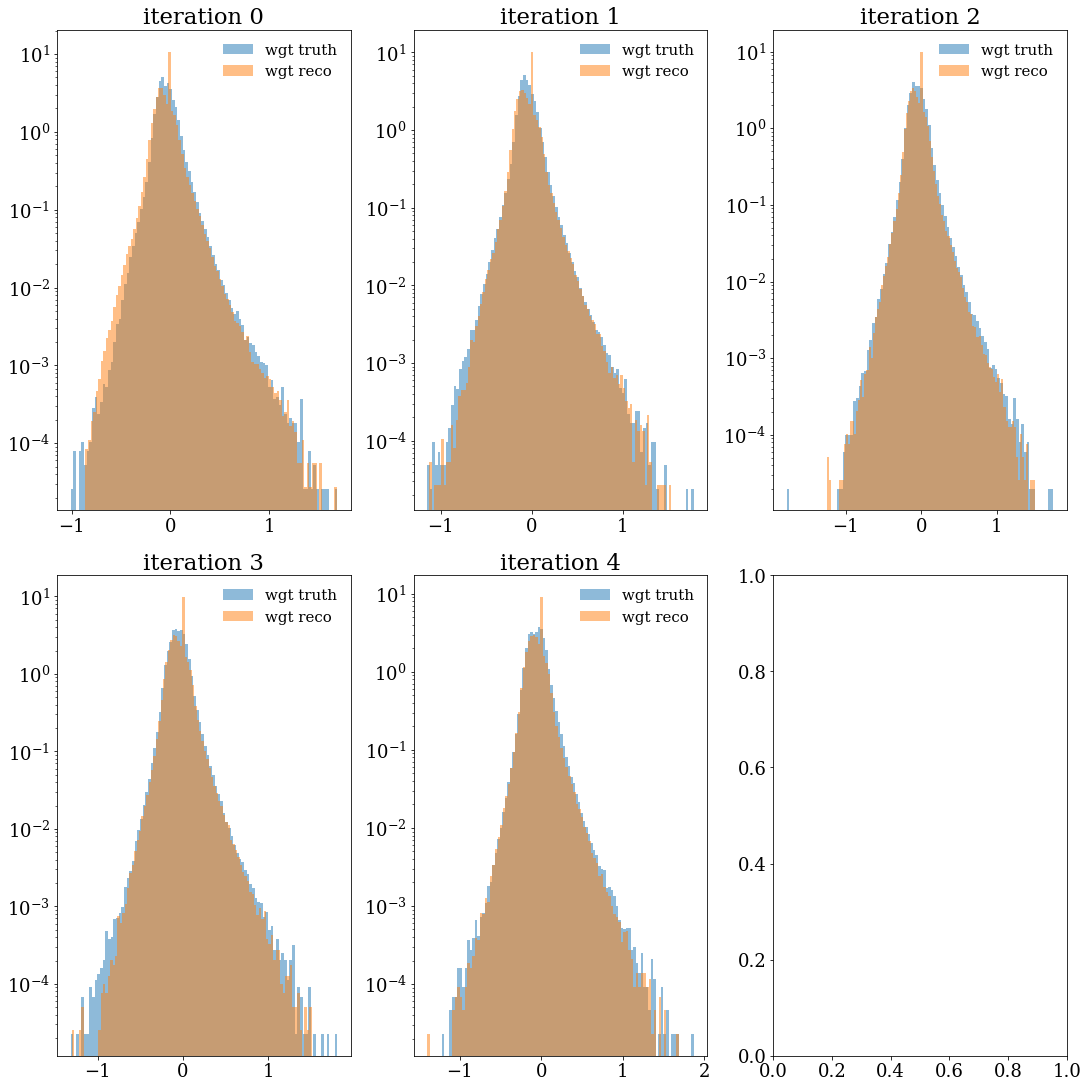

In [40]:
fig, ax = plt.subplots(2,
                           3,
                           figsize=(15, 15),
                           constrained_layout=True)
ax = ax.flatten()
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)
    
    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

In [41]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth',
       'pass_reco', 'pass_truth', 'jet_px', 'jet_py', 'jet_pz', 'jet_qt',
       'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi', 'qt_dot_ept',
       'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte', 'gen_logQ2',
       'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py', 'genjet_pz', 'genjet_qt',
       'genjet_qtnorm', 'gene_phi', 'genjet_dphi', 'genqt_px', 'genqt_py',
       'genqt_phi', 'genqt_dot_ept', 'genqt_dphi', 'genqt_cos2phi',
       'weight_reco', 'weight_truth', 'weight_reco_next', 'weight_truth_next',
       'weight_reco_previous', 'weight_truth_previous'],
      dtype='object')

## MC at reco level reweighted vs data

The query is: pass_reco==1 
ITERATION: 4


No handles with labels found to put in legend.
<ipython-input-42-f8d5e67ab508>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


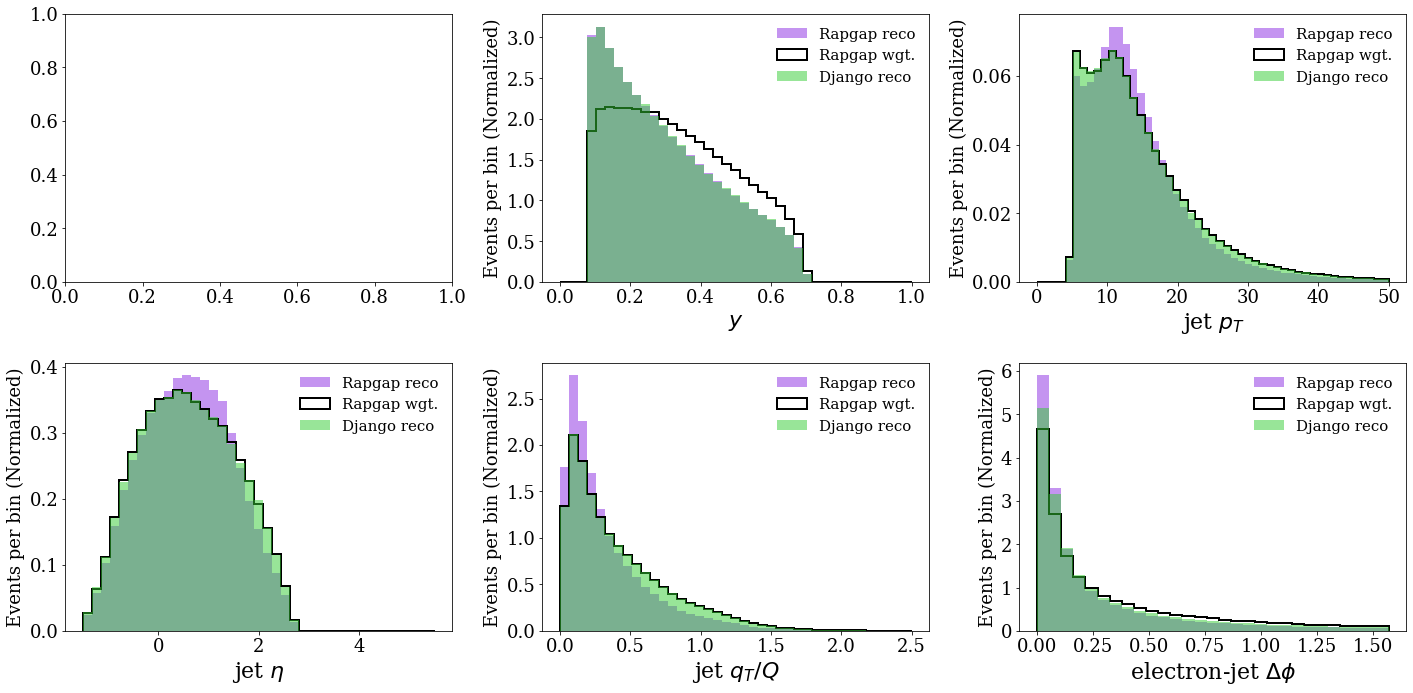

In [42]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = altmc_name + ' reco'

color1='blueviolet'
color2='limegreen'
#color1='red'
#color2='blue'
for i in range(iterations-2,iterations-1):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           3,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[1].set_xlabel(r'$y$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['y'],bins=bins, weights= mc_cut.query(query)['wgt'],label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['y'], weights = data_cut.query(query)['wgt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    #bins = np.linspace(2, 4,25 )

    #ax[0].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    #ax[0].set_ylabel('Events per bin (Normalized)')
    #ax[0].hist(mc_cut.query(query)['logQ2'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    #ax[0].hist(mc_cut.query(query)['logQ2'],
    #           bins=bins,
    #           weights=mc_cut.query(query)['weight_reco'],
    #           label=label2,
    #           **plot_style_1)#

    #ax[0].hist(data_cut.query(query)['logQ2'],
    ##           bins=bins,
    #           label=label3,
    #           **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['jet_pt'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,5.5,40 )

    ax[3].set_xlabel('jet $\eta $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['jet_eta'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,40)
    
    ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[4].legend(frameon=False,loc='best')


    bins = np.linspace(0,np.pi/2.0,30)

    ax[5].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['jet_dphi'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['jet_dphi'], weights = data_cut.query(query)['wgt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[5].legend(frameon=False,loc='best')
    #ax[7].set_yscale('log')
    
    plt.tight_layout()
    fig.savefig('figures/ClosureTestRealDataMC_comparison_inclusivejet_%i_iter_%s_%s_%s_data_%s.png'%(i,mc_name,mc_tag,period,data_tag)) 
    
    

## Plot unfolded results

ITERATION: 4


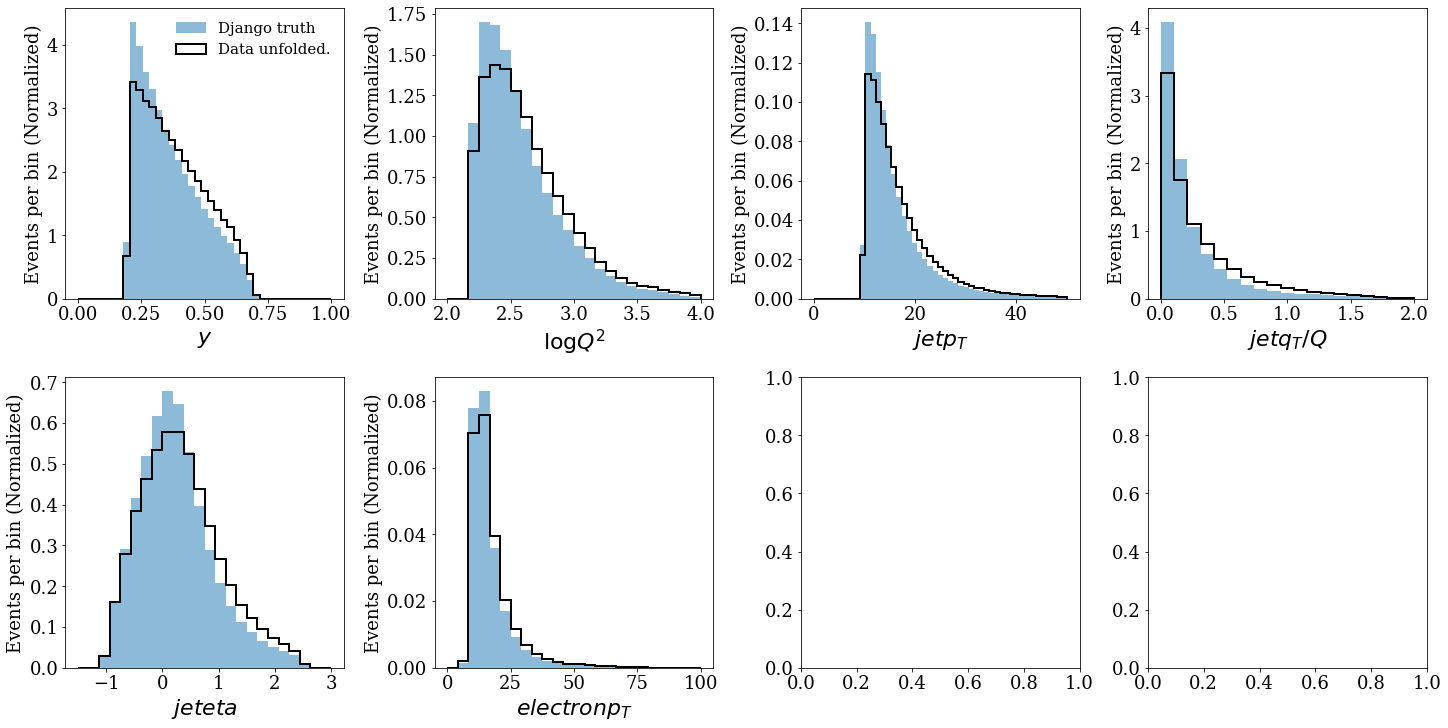

In [43]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
# ##track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

#for i in range(len(weights)):
for i in range(iterations-2,iterations-1):

    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    ax = ax.flatten()
    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)



    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['genjet_pt'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(0,2,20 )

    
    ax[3].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(-1.5,3,25 )

    ax[4].set_xlabel(r'$jet eta $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['genjet_eta'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    
    bins = np.linspace(0,100,25)

    ax[5].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['gene_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

## define binning

In [44]:
qtbins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
qtbins[0] = 0.0
print (qtbins)

[0.         0.02341478 0.06510462 0.13933307 0.27149627 0.50681187
 0.92578957 1.67177624 3.        ]


## Jet pT spectrum data reco vs MC reco

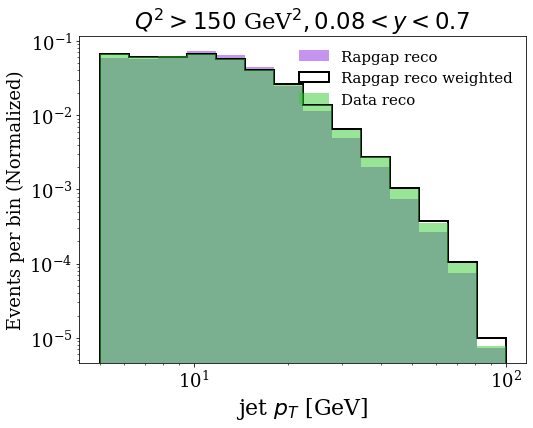

In [45]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),15)
#bins = np.array([5,10,14,21,29,47,71,127])

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, 
         label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_jetpt_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


[0.         0.0063609  0.01407051 0.02341478 0.03474032 0.04846721
 0.06510462 0.08526965 0.10971029 0.13933307 0.17523676 0.21875313
 0.27149627 0.33542254 0.4129031  0.50681187 0.62063213 0.75858569
 0.92578957 1.12844568 1.37407099 1.67177624 2.03260396 2.469938
 3.        ]


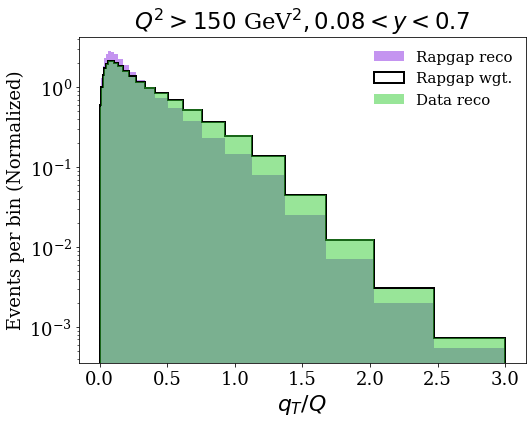

In [46]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(0.03),np.log10(3.03),25) - 0.03
bins[0] = 0.0
print (bins)
plt.hist(mc_cut.query(query)['jet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' wgt.',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'$q_{T}/Q $ ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')


fig.savefig('figures/ClosureTestRealDataMC_jetqtnorm_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


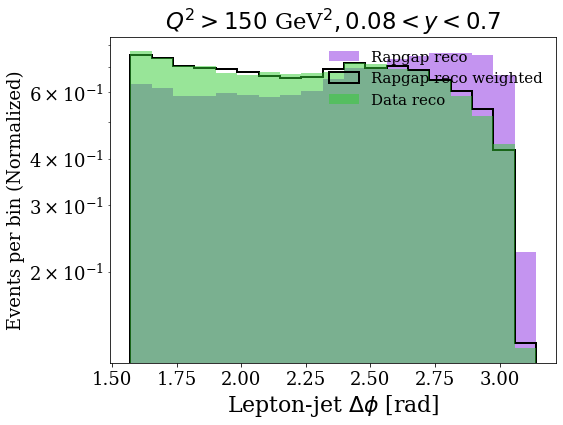

In [47]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
#bins = np.logspace(np.log10(5),np.log10(100),20)
#bins = np.array([5,10,14,21,29,47,71,127])
bins = np.linspace(np.pi/2.0,np.pi,20)
#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_dphi'], bins=bins,  weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'Lepton-jet $\Delta\phi$ [rad]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/ClosureTestRealDataMC_dphi_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


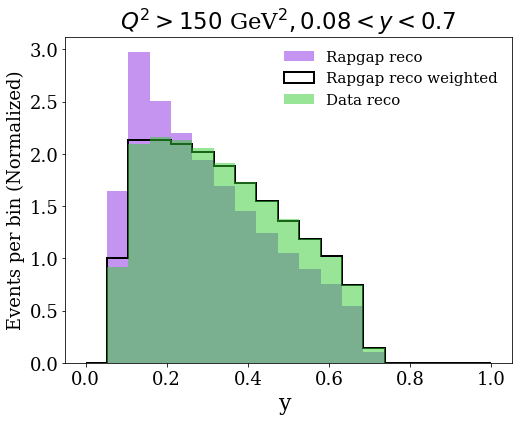

In [48]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.linspace(0,1,20)

plt.hist(mc_cut.query(query)['y'], bins=bins, weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['y'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
#plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'y ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/DataMC_y_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [49]:
print(len(mc_cut['y']))
print(len(mc_cut.query('pass_reco==1')['y']))

1414891
1099371


## Data/MC agreement with differential 

Q>12.00 and Q<20.00 and pass_reco==1 and jet_pt>10
###########
Q>20.00 and Q<30.00 and pass_reco==1 and jet_pt>10
###########
Q>30.00 and Q<100.00 and pass_reco==1 and jet_pt>10
###########


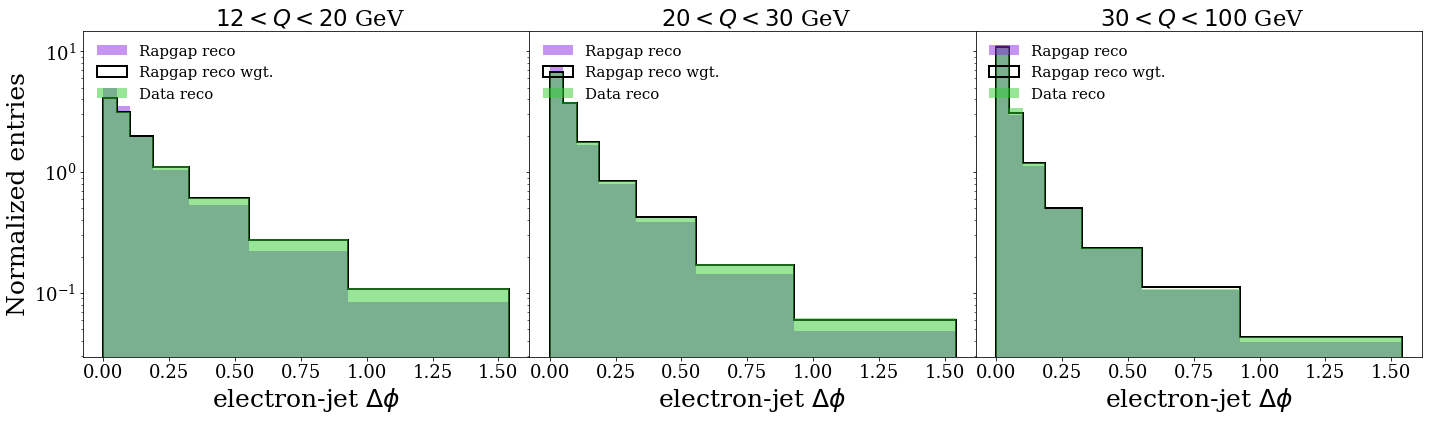

In [50]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 15}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f < Q < %2.0f$ GeV'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/RealDataMCcomparison_dphi_diff_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


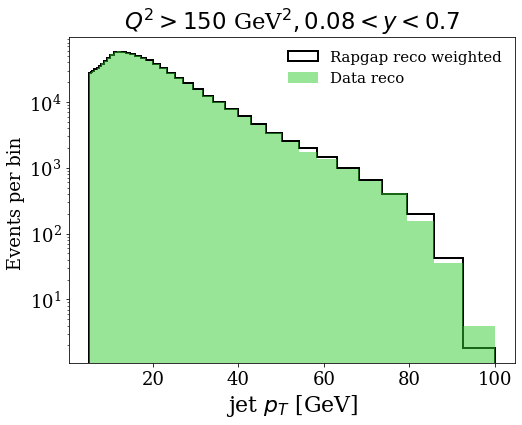

In [51]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),40)

plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label='Rapgap reco weighted', color='black', histtype='step', lw=2
               )

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               color=color2, alpha=0.5)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin ')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  



In [52]:
altmc_cut = altmc

## Define fiducial region of the measurement

In [53]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0 '


## Plot data, and unfolded results and MC truth

[12.33899634 18.11116979 26.58356175 39.01933247 57.27254762 84.06460345]
[1.02941110e-01 4.74014570e-02 1.33120126e-02 2.92444114e-03
 6.29258025e-04 5.89254658e-05]
[1.02455804e-01 4.87545901e-02 1.30508619e-02 2.73765922e-03
 5.64143810e-04 5.22761964e-05]
[1.00473673 0.97224603 1.02001023 1.06822687 1.11542131 1.12719497]
[1.00183793 0.98740741 1.02595336 0.99915262 1.00018676 0.97179382]


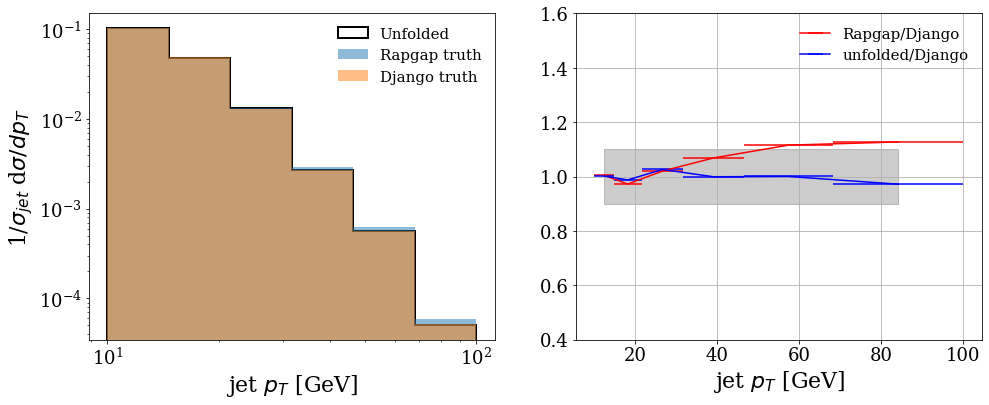

In [54]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
cut = fiducialregion 
bins = np.logspace(np.log10(10),np.log10(100),7)
y, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label = 'Unfolded',**plot_style_1)

mc1, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_pt'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
mc2 , x, _ = ax[0].hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2

ax[0].legend()
ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=22)
ax[0].set_xlabel('jet $p_{T}$ [GeV]',fontsize=22)
ax[1].set_xlabel('jet $p_{T}$ [GeV]',fontsize=22)

ax[0].set_yscale('log')
ax[0].set_xscale('log')


print(x)
print(mc1)
print(mc2)
print(np.true_divide(mc1,mc2))
print(np.true_divide(y, mc2))

ax[1].errorbar(x,np.true_divide(mc1,mc2) ,xerr=xerr,label= mc_name+'/'+altmc_name,color='red')
ax[1].errorbar(x,np.true_divide(y,mc2) ,xerr=xerr, label='unfolded/'+altmc_name,color='blue')
ax[1].legend()
ax[1].set_ylim([0.4,1.6])
ax[1].grid()
ax[1].fill_between(x,0.9,1.1,alpha=0.2,color='black')
fig.savefig('figures/ClosureTests_Unfolded_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 
fig.savefig('figures/ClosureTests_Unfolded_jetpt_%s_%s_%s_data_%s.pdf'%(mc_name,mc_tag,period,data_tag)) 

with open('outputfiles/NonClosure_jetpt_%s.npy'%(mc_name) , 'wb') as f:
    np.save(f, np.true_divide(y,mc2))
plt.show()

[0.22439948 0.67319843 1.12199738 1.57079633 2.01959528 2.46839423
 2.91719318]
[0.42703683 0.42085715 0.38119653 0.3129302  0.2582552  0.22184912
 0.20604417]
[0.42878334 0.4015477  0.35499178 0.30756154 0.26882813 0.23879155
 0.22766517]
[0.99592683 1.04808757 1.07381791 1.01745557 0.96067031 0.9290493
 0.90503156]
[0.93775472 1.01055439 1.05899088 1.03509255 1.00402651 0.99281363
 0.96200936]


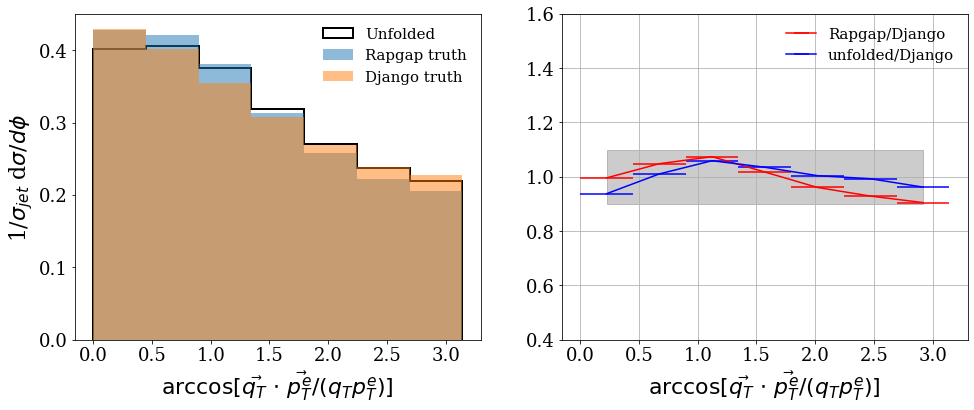

In [55]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
cut = fiducialregion + ' and genjet_qtnorm<0.25'
bins = np.linspace(0,np.pi,8) 
y, x , _ = ax[0].hist(mc_cut.query(cut)['genqt_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label = 'Unfolded',**plot_style_1)

mc1, x , _ = ax[0].hist(mc_cut.query(cut)['genqt_dphi'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
mc2 , x, _ = ax[0].hist(altmc_cut.query(cut)['genqt_dphi'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2

ax[0].legend()
ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/d\phi$ ',fontsize=22)
ax[0].set_xlabel(r'$\arccos[\vec{q_{T}}$ $\cdot$ $\vec{p_{T}^{e}}/(q_{T}p_{T}^{e})]$ ',fontsize=22)
ax[1].set_xlabel(r'$\arccos[\vec{q_{T}}$ $\cdot$ $\vec{p_{T}^{e}}/(q_{T}p_{T}^{e})]$ ',fontsize=22)

print(x)
print(mc1)
print(mc2)
print(np.true_divide(mc1,mc2))
print(np.true_divide(y, mc2))

ax[1].errorbar(x,np.true_divide(mc1,mc2) ,xerr=xerr,label= mc_name+'/'+altmc_name,color='red')
ax[1].errorbar(x,np.true_divide(y,mc2) ,xerr=xerr, label='unfolded/'+altmc_name,color='blue')
ax[1].legend()
ax[1].set_ylim([0.4,1.6])
ax[1].grid()
ax[1].fill_between(x,0.9,1.1,alpha=0.2,color='black')
fig.savefig('figures/ClosureTests_Unfolded_jetqtphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 
fig.savefig('figures/ClosureTests_Unfolded_jetqtphi_%s_%s_%s_data_%s.pdf'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [56]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion + 'and genjet_qtnorm<0.3'
bins = np.linspace(0,np.pi,10) 

y,x = np.histogram(mc_cut.query(cut)['genqt_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
x = (x[1:]+x[:-1])/2

<Figure size 576x432 with 0 Axes>

In [57]:
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
print(bins)
print(bins[1:])

[-3.46944695e-18  2.34147778e-02  6.51046164e-02  1.39333065e-01
  2.71496269e-01  5.06811874e-01  9.25789566e-01  1.67177624e+00
  3.00000000e+00]
[0.02341478 0.06510462 0.13933307 0.27149627 0.50681187 0.92578957
 1.67177624 3.        ]


[0.03255231 0.10221884 0.20541467 0.38915407 0.71630072 1.2987829
 2.33588812]
[4.24182599 2.83865581 1.43280104 0.68854484 0.24365011 0.06972261
 0.00575468]
[3.1547287  2.71404993 1.49380078 0.79435814 0.31961886 0.08939872
 0.00617298]
[1.34459296 1.04591142 0.95916474 0.86679396 0.76231456 0.77990619
 0.93223794]
[1.08640418 0.92691113 0.96810703 1.00244302 0.9890204  1.05187089
 1.10110723]


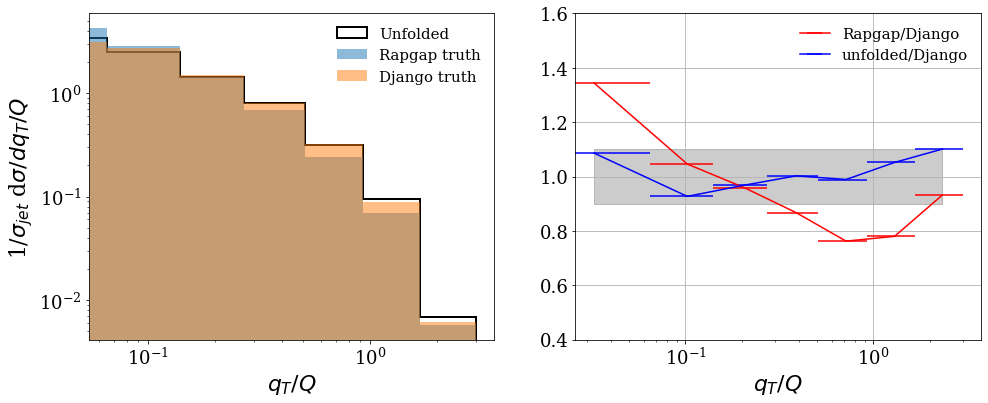

In [58]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
cut = fiducialregion
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0

y, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label = 'Unfolded',**plot_style_1)

mc1, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
mc2 , x, _ = ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2

ax[0].legend()
ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dq_{T}/Q$ ',fontsize=22)
ax[0].set_xlabel('$q_{T}/Q$',fontsize=22)
ax[1].set_xlabel('$q_{T}/Q$',fontsize=22)
ax[1].fill_between(x,0.9,1.1,alpha=0.2,color='black')

ax[0].set_yscale('log')
ax[0].set_xscale('log')


print(x)
print(mc1)
print(mc2)
print(np.true_divide(mc1,mc2))
print(np.true_divide(y, mc2))

ax[1].errorbar(x,np.true_divide(mc1,mc2) ,xerr=xerr,label= mc_name+'/'+altmc_name,color='red')
ax[1].errorbar(x,np.true_divide(y,mc2) ,xerr=xerr, label='unfolded/'+altmc_name,color='blue')
ax[1].legend()
ax[1].set_ylim([0.4,1.6])
ax[1].grid()
ax[1].set_xscale('log')
fig.savefig('figures/ClosureTests_Unfolded_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 
fig.savefig('figures/ClosureTests_Unfolded_jetqt_%s_%s_%s_data_%s.pdf'%(mc_name,mc_tag,period,data_tag)) 

with open('outputfiles/NonClosure_jetqt_%s.npy'%(mc_name) , 'wb') as f:
    np.save(f, np.true_divide(y,mc2))
plt.show()

[-0.65  0.05  0.75  1.45  2.15]
[0.30678066 0.5650603  0.37845959 0.13140219 0.04686869]
[0.28575218 0.54397077 0.39451131 0.14936185 0.05497531]
[1.0735899  1.03876959 0.9593124  0.8797574  0.85254074]
[0.97603827 1.01109495 0.99106839 1.00963954 1.05267148]


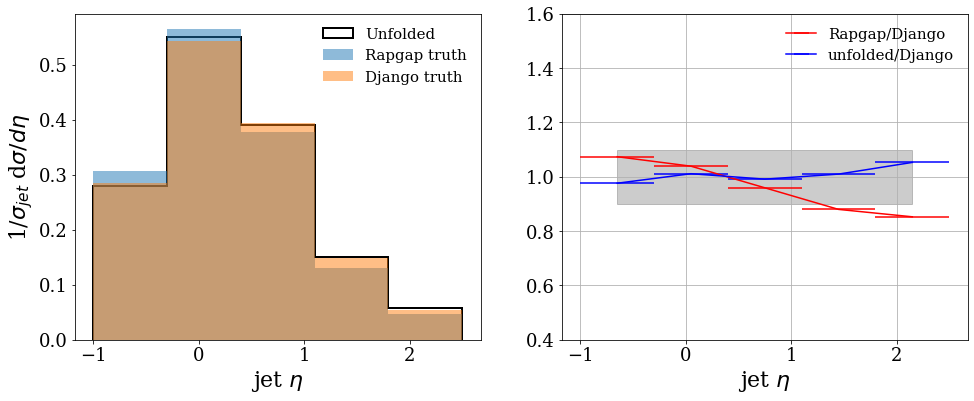

In [59]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
cut = fiducialregion
bins = np.linspace(-1,2.5,6)


y, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'],label = 'Unfolded',**plot_style_1)

mc1, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_eta'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
mc2 , x, _ = ax[0].hist(altmc_cut.query(cut)['genjet_eta'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2

ax[0].legend()
ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/d\eta$ ',fontsize=22)
ax[0].set_xlabel('jet $\eta$',fontsize=22)
ax[1].set_xlabel('jet $\eta$',fontsize=22)

#ax[0].set_yscale('log')
#ax[0].set_xscale('log')


print(x)
print(mc1)
print(mc2)
print(np.true_divide(mc1,mc2))
print(np.true_divide(y, mc2))

ax[1].errorbar(x,np.true_divide(mc1,mc2) ,xerr=xerr,label= mc_name+'/'+altmc_name,color='red')
ax[1].errorbar(x,np.true_divide(y,mc2) ,xerr=xerr, label='unfolded/'+altmc_name,color='blue')
ax[1].legend()
ax[1].set_ylim([0.4,1.6])
ax[1].fill_between(x,0.9,1.1,alpha=0.2,color='black')

ax[1].grid()#ax[1].set_xscale('log')
fig.savefig('figures/ClosureTests_Unfolded_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 
fig.savefig('figures/ClosureTests_Unfolded_jeteta_%s_%s_%s_data_%s.pdf'%(mc_name,mc_tag,period,data_tag)) 

with open('outputfiles/NonClosure_jeteta_%s.npy'%(mc_name) , 'wb') as f:
    np.save(f, np.true_divide(y,mc2))
plt.show()
plt.show()

In [60]:
import numpy as np
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
print (bins)

[0.         0.05069951 0.10235664 0.18708038 0.32603721 0.55394268
 0.92773432 1.54079633]


In [61]:
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
print(bins)

[0.         0.06510462 0.13933307 0.27149627 0.50681187 0.92578957
 1.67177624 3.        ]


[0.02534976 0.07652808 0.14471851 0.2565588  0.43998995 0.7408385
 1.23426532]
[6.8037267  3.3211179  1.73109883 0.90329316 0.44455202 0.18287202
 0.06792   ]
[5.68845636 3.24059275 1.77912466 0.97309326 0.51310321 0.2317429
 0.08919764]
[1.19605852 1.0248489  0.97300592 0.92826988 0.86639883 0.78911597
 0.76145508]
[1.04556781 0.94531818 0.9549371  0.97205027 1.00853412 1.02790312
 1.05794518]


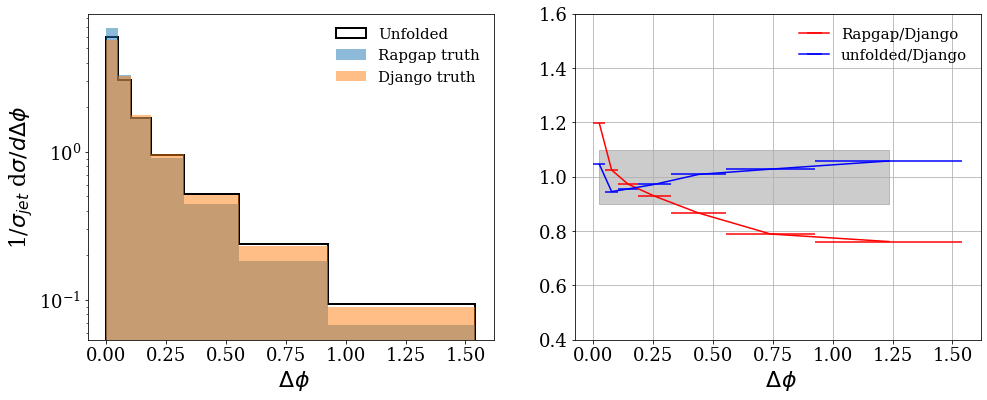

[1.04556781 0.94531818 0.9549371  0.97205027 1.00853412 1.02790312
 1.05794518]


In [63]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
cut = fiducialregion
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0

y, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'],label = 'Unfolded',**plot_style_1)

mc1, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
mc2 , x, _ = ax[0].hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2

ax[0].legend()
ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/d\Delta\phi$ ',fontsize=22)
#ax[0].set_ylabel('Normalized entries', fontsize=22)
ax[0].set_xlabel(' $\Delta\phi$',fontsize=22)
ax[1].set_xlabel(' $\Delta\phi$',fontsize=22)

ax[0].set_yscale('log')
#ax[0].set_xscale('log')


print(x)
print(mc1)
print(mc2)
print(np.true_divide(mc1,mc2))
print(np.true_divide(y, mc2))

ax[1].errorbar(x,np.true_divide(mc1,mc2) ,xerr=xerr,label= mc_name+'/'+altmc_name,color='red')
ax[1].errorbar(x,np.true_divide(y,mc2) ,xerr=xerr, label='unfolded/'+altmc_name,color='blue')
ax[1].legend()
ax[1].set_ylim([0.4,1.6])
ax[1].grid()#ax[1].set_xscale('log')
ax[1].fill_between(x,0.9,1.1,alpha=0.2,color='black')

fig.savefig('figures/ClosureTests_Unfolded_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag))
fig.savefig('figures/ClosureTests_Unfolded_jetdphi_%s_%s_%s_data_%s.pdf'%(mc_name,mc_tag,period,data_tag)) 

with open('outputfiles/NonClosure_dphi_%s.npy'%(mc_name) , 'wb') as f:
    np.save(f, np.true_divide(y,mc2))
plt.show()

print(np.true_divide(y,mc2))

# Termino

# FIN

## Checking stability of the result vs number of iterations

In [ ]:
bins = np.logspace(np.log10(10),np.log10(100),7)
lumi=1

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_next'])
total_next = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_next)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_previous'])
total_previous = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_previous)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(10),np.log10(100),7)


cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')
ax[1].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
ax[0].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)

#ax[0].set_ylim(bottom=1)
#fig.savefig('figures/Iterations_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(np.pi/2.0,np.pi,10) 

cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')



ax[1].set_xlabel(r'$\Delta\phi$ ',fontsize=18)
ax[0].set_xlabel(r'$\Delta\phi$ ',fontsize=18)

fig.savefig('figures/Iterations_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dq_{T}/Q$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')
ax[0].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
ax[1].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)

ax[0].legend()
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')

fig.savefig('figures/Iterations_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(-1,2.5,6)
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
#ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/d\eta$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')

ax[1].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_ylim(bottom=0.0)

fig.savefig('figures/Iterations_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()